## 项目一：手把手教你写图神经网络势


### 1. 环境配置
所有流程只需安装ASE，PyTorch，和ASAP3三个python包

In [1]:
#!pip install pytorch ase asap3

### 2. 数据准备

熟练操作ASE可以让模型的数据准备变得非常简单，首先我们需要先把所有的训练集结构给收集起来，这些结构可以是从你日常DFT计算中得到一些结构，也可以是从网上下载的一些数据，这里我们以PNAS中一篇计算液体水的paper ([Cheng et al.](https://www.pnas.org/doi/full/10.1073/pnas.1815117116)) 为例。

In [3]:
#!wget https://github.com/BingqingCheng/ab-initio-thermodynamics-of-water/raw/master/training-set/dataset_1593.xyz

以上代码可以获得我们需要的DFT数据，当然你也可以自己通过DFT计算软件产生这些结构数据。

接下来我们将使用ASE来读取这些数据，并将其转换成ASE二进制traj格式来节省空间。

In [4]:
# 加载相关的模块
import torch
import asap3
import numpy as np
import json
import time
from typing import List, Dict, Optional
from ase.io import read, write, Trajectory
from ase.calculators.singlepoint import SinglePointCalculator

In [59]:
# 先处理一下数据，推荐使用ase的默认格式traj来存储结构，内存占用小，而且速度很快
images = read('dataset/dataset_1593.xyz', index=':')
for atoms in images:
    calc = SinglePointCalculator(atoms, energy=atoms.info.pop('TotEnergy'), forces=atoms.arrays.pop('force'))
    atoms.calc = calc
    
write('dataset_1593.traj', images)

In [62]:
traj = Trajectory('dataset_1593.traj')

ASE中每个结构由一个`Atomsobject`来表示，而以上代码`images`是一个`Atoms`组成的list。 注意到我们这里还使用了一个`SinglePointCalculator`来处理`enery`和`force`，这是为了更加符合ASE的使用习惯，在`Atoms object`中我们通常使用`atoms.info`来储存与其相关的性质，使用`calculator`来获得`Atoms`的`energy`，`force`以及`stress`。 最后我们将这些`atoms`也即原子结构储存成`Trajectory`，这一文件可以使我们的数据读取更加快速。

这一方法同样适合于其他格式的原子结构，例如VASP的输出文件OUTCAR，也可以通过`read`函数来将其储存成`Trajectory`。

In [ ]:
# 以下代码可以实现用ASE读取OUTCAR，并转换成Trajectory文件
# images = read('path_to_OUTCAR', ':')          # uncomment when needed
# write('dft_structures.traj', images)

我们可以使用ASE自带的GUI来查看一下这个结构。

In [6]:
from ase.visualize import view

view(images[0], viewer='x3d')

In [7]:
len(images)

1593

#### 小测验：
1. 把dataset中OUTCAR转换成.traj格式
2. 在刚刚的结构中，每两个结构提取一个结构，把它储存成另一个compressed.traj文件（提示：使用::2对列表切片）

In [9]:
# 在这里输入正确的代码
vasp_images = read('dataset/OUTCAR', ':')

In [10]:
len(vasp_images)

108

In [12]:
view(vasp_images[-1], viewer='x3d')

<div style="display: flex; justify-content: space-between;">
    <div style="flex: 1; text-align: center; margin: 5px;">
        <img src="figures/neighbor_list.png" alt="neighborlist" style="width: 100%; max-width: 350px;">
        <p style="text-align: center;">近邻原子矩阵示意</p>
    </div>
    <div style="flex: 1; text-align: center; margin: 5px;">
        <img src="figures/soap.gif" alt="soap" style="width: 100%; max-width: 300px;">
        <p style="text-align: center;">基于Smooth Overlap of Atomic Positions (SOAP) 描述符的模型</p>
    </div>
</div>


对于目前流行的绝大多数机器学习势，它们处理的都是单个原子及其周围（截断半径$R_c$内）的原子环境，所以它们的输入为原子序数$\vec{Z_i}$和坐标$\vec{R_i}$。其中坐标用于获得$\vec{R_{ij}}=\vec{R_j}-\vec{R_i}$或$\|\vec{R_{ij}}\|$，也就是近邻原子与中心原子坐标的矢量差及其模。

所以我们首先要先获得每个原子的neighbor list，也即是小于截断半径$R_c$的所有近邻原子index，以及它们的坐标。Neighbor list的计算其实比较复杂，最简单无脑的方式是把所有原子相互间的距离给计算出来，然后把小于$R_c$的近邻原子储存起来，然而这种方法在结构所包含原子数非常多的时候计算耗时会特别长（计算复杂度为$O(n^2)$），而且无法处理周期性边界条件问题。幸好Neighbor list计算已经有了很成熟的linked-cell neighborlist算法，目前lammps所用的便是这一算法，它可以大大减小计算neighbor list的时间，而且可以实现并行计算。我们之前提到的`asap3`便是利用linked-cell neighborlist算法来获得neighbor list的python程序包。

下面我们展示如何使用`asap3`获得neighbor list。

In [13]:
atoms = images[-1]         # 以数据集中最后一个结构为例
nl = asap3.FullNeighborList(rCut=5.0, atoms=atoms)        # cutoff设置为5.0 Å

# 以下代码表示计算结构中第0个原子的neighbor list，其中indices, n_diff, n_dist_square分别为近邻原子的索引编号，近邻原子与中心原子矢量差，和两个原子距离的平方
indices, n_diff, n_dist_square = nl.get_neighbors(0)

这样我们便获得了一个原子的所有neighbor及其相应的位置信息，其中indices, n_diff, n_dist_square分别为近邻原子的索引编号，近邻原子与中心原子矢量差，和两个原子距离的平方。

但是一个原子信息是不够的，实际的模型需要获得所有原子neighbor list的信息，这里我们通过以下函数来实现。

In [21]:
def get_neighborlist(cutoff, atoms):      
    nl = asap3.FullNeighborList(cutoff, atoms)
    pair_i_idx = []
    pair_j_idx = []
    n_diff = []
    for i in range(len(atoms)):
        indices, diff, _ = nl.get_neighbors(i)
        pair_i_idx += [i] * len(indices)               # local index of pair i
        pair_j_idx.append(indices)   # local index of pair j
        n_diff.append(diff)

    pair_j_idx = np.concatenate(pair_j_idx)
    pairs = np.stack((pair_i_idx, pair_j_idx), axis=1)
    n_diff = np.concatenate(n_diff)
    
    return pairs, n_diff

pairs, n_diff = get_neighborlist(5.0, atoms)

这样我们便获得了$n\times 2$的索引矩阵`pairs`和$n\times 3$的`n_diff`，其中n为所有pair的数目。

了解如何获得最关键的neighbor list信息之后，我们将创建一个`class AseDataReader`，来帮助我们读取ase数据并将其转化成pytorch tensor，为训练做好准备。

In [64]:
class AseDataReader:
    def __init__(self, cutoff=5.0):            
        self.cutoff = cutoff
        self.neighbor_list = asap3.FullNeighborList(self.cutoff, atoms=None)

    def __call__(self, atoms):
        atoms_data = {
            'num_atoms': torch.tensor([atoms.get_global_number_of_atoms()]),
            'elems': torch.tensor(atoms.numbers),
            'coord': torch.tensor(atoms.positions, dtype=torch.float),
        }
        atoms_data['image_idx'] = torch.zeros((atoms_data['num_atoms'],), dtype=torch.long)
        if atoms.pbc.any():            
            atoms_data['cell'] = torch.tensor(atoms.cell[:], dtype=torch.float)

        pairs, n_diff = self.get_neighborlist(atoms)    
        atoms_data['pairs'] = torch.from_numpy(pairs)
        atoms_data['n_diff'] = torch.from_numpy(n_diff).float()
        atoms_data['num_pairs'] = torch.tensor([pairs.shape[0]])
        
        # 当atoms有能量和力输出时，读取这些输出。这些数据对训练模型是必要的，但是对预测不是必要的。
        try:
            energy = torch.tensor([atoms.get_potential_energy()], dtype=torch.float)
            atoms_data['energy'] = energy
        except (AttributeError, RuntimeError):
            pass
        
        try: 
            forces = torch.tensor(atoms.get_forces(apply_constraint=False), dtype=torch.float)
            atoms_data['forces'] = forces
        except (AttributeError, RuntimeError):
            pass
        
        return atoms_data
    
    def get_neighborlist(self, atoms):        
        self.neighbor_list.check_and_update(atoms)            # 更新结构
        pair_i_idx = []
        pair_j_idx = []
        n_diff = []
        for i in range(len(atoms)):
            indices, diff, _ = self.neighbor_list.get_neighbors(i)
            pair_i_idx += [i] * len(indices)               # local index of pair i
            pair_j_idx.append(indices)   # local index of pair j
            n_diff.append(diff)

        pair_j_idx = np.concatenate(pair_j_idx)
        pairs = np.stack((pair_i_idx, pair_j_idx), axis=1)
        n_diff = np.concatenate(n_diff)
        
        return pairs, n_diff

我们来测试一下这个class。这个类的输出为一个`atoms_data`字典，里面记录了关键的neighbor list信息，每个`Atoms`的原子数目，每个原子的原子序数，以及数据的label，也即是energy和force。

In [65]:
ase_reader = AseDataReader(cutoff=5.0)
atoms_data = ase_reader(atoms)

In [26]:
atoms_data

{'num_atoms': tensor([192]),
 'elems': tensor([8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1]),
 'coord': tensor([[ 2.4921e+01, -2.4575e+00, -3.6641e+01],
         [ 2.3039e+01, -3.1130e+00, -3.7228e+01],
         [ 2.5208e+01, -2.3283e+00, -3.4824e+01],
         [ 5.1514e+01,  4.9502e+01,  1.2347e+00],
         [ 5.2856e+01,  4.9982e+01,  6.5408e-01],
         [ 5.1248e+01,  4.7804e+01,  1.6649e+00],
   

有了这个类后，我们还需要创建一个类`AseDataset`，它必须继承`torch.utils.data.Dataset`，它可以帮助我们以mini-batch的方式来提取`Trajectory`中的数据。这样一来我们便获得了一个标准的pytorch的Dataset。

In [67]:
class AseDataset(torch.utils.data.Dataset):
    def __init__(self, ase_db, cutoff=5.0, **kwargs):
        super().__init__(**kwargs)
        
        # 可以使用一个数据集路径的字符串，或者ASE中的Trajectory或list[Atoms]来初始化这个类
        if isinstance(ase_db, str):
            self.db = Trajectory(ase_db)
        else:
            self.db = ase_db
        
        self.cutoff = cutoff
        self.atoms_reader = AseDataReader(cutoff)
        
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, idx):
        atoms = self.db[idx]
        atoms_data = self.atoms_reader(atoms)
        return atoms_data

In [36]:
dataset = AseDataset('dataset_1593.traj', cutoff=5.0)
dataset[100]

{'num_atoms': tensor([192]),
 'elems': tensor([8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1]),
 'coord': tensor([[ 1.1667e+01,  1.1634e-01,  4.8152e+00],
         [ 1.3655e+01,  5.8313e-01,  4.5436e+00],
         [ 1.0940e+01,  1.6446e+00,  4.1172e+00],
         [ 2.2269e+01,  3.8750e-01,  1.4985e+01],
         [ 2.2608e+01,  1.5549e+00,  1.3526e+01],
         [ 2.0447e+01,  4.9353e-01,  1.5258e+01],
   

有了`AseDataset`之后，我们便可以通过`torch.utils.data.Dataloader`来创建一个`Dataloader`。

但对于数据的处理要注意一点，对于原子结构数据来说，每个`Atoms` object包含的原子数可能是不同的，同时每个原子的neighbor list大小也可能是不一样的，因此我们便不能再使用Dataloader默认的[collate_fn函数](https://pytorch.org/docs/stable/data.html)来batching。

这是整个机器学习势开发过程中的一大难点，我们必须使用indexing的方式来处理数据并进行计算。

我们这里创建一个`collate_atomsdata`函数来batching `AseDataset`。这个函数有三个作用，1). 把所有的物理量，比如能量、力、坐标等等数据堆叠起来；2）为每个原子创建一个image_idx标签，表示每个原子具体属于哪一个结构；3）为pair的index加上offset。

In [40]:
def collate_atomsdata(atoms_data: List[dict], pin_memory=True) -> Dict:
    # convert from list of dicts to dict of lists
    dict_of_lists = {k: [dic[k] for dic in atoms_data] for k in atoms_data[0]}
    if pin_memory:
        pin = lambda x: x.pin_memory()
    else:
        pin = lambda x: x
    
    # concatenate tensors
    collated = {k: torch.cat(v) if v[0].shape else torch.stack(v) 
                for k, v in dict_of_lists.items()}
    
    # create image index for each atom
    image_idx = torch.repeat_interleave(
        torch.arange(len(atoms_data)), collated['num_atoms'], dim=0
    )
    collated['image_idx'] = image_idx
    
    # shift index of edges (because of batching)
    if  'pairs' in collated:
        edge_offset = torch.zeros_like(collated['num_atoms'])
        edge_offset[1:] = collated['num_atoms'][:-1]
        edge_offset = torch.cumsum(edge_offset, dim=0)
        edge_offset = torch.repeat_interleave(edge_offset, collated['num_pairs'])
        edge_idx = collated['pairs'] + edge_offset.unsqueeze(-1)
        collated['pairs'] = edge_idx
    
    return collated

有了这个函数以后，我们便可以创建自己的dataloader，并将所有的dataset分为training，validation两部分。我们这里还定义了一个split_data函数，用于选取training set和validation set，并将splits存储于datasplits.json文件中。

In [41]:
def split_data(dataset, split_file=None, val_ratio=0.1, test_ratio=None):
    if split_file:
        with open(split_file, 'r') as f:
            splits = json.load(f)
    else:
        n = len(dataset)
        indices = np.random.permutation(n)
        num_validation = int(n * val_ratio)
        num_train = n - num_validation
        if test_ratio is not None:
            num_test = int(n * test_ratio)
            num_train -= num_test
        splits = {
            'train': indices[:num_train].tolist(),
            'validation': indices[num_train:num_train + num_validation].tolist(),                    
        }
        if test_ratio is not None:
            splits['test'] = indices[num_train+num_validation:].tolist()
    
    with open('datasplits.json', 'w') as f:
        json.dump(splits, f)
    
    datasplits = {}
    for k, v in splits.items():
        datasplits[k] = torch.utils.data.Subset(dataset, v)
    return datasplits

有了这两个函数以后我们的数据处理部分就大功告成了，以下展示了我们如何得到dataloader。可以用最后两行代码查看从dataloader中所得到的数据。

In [44]:
dataset = AseDataset('dataset_1593.traj', cutoff=5.0)
np.random.seed(123)
datasplits = split_data(dataset)
train_loader = torch.utils.data.DataLoader(
    dataset=datasplits['train'],
    batch_size=16,
    collate_fn=collate_atomsdata,
)
val_loader = torch.utils.data.DataLoader(
    datasplits['validation'],
    batch_size=16,
    collate_fn=collate_atomsdata,
)

next(iter(train_loader))
next(iter(val_loader))

{'num_atoms': tensor([192]),
 'elems': tensor([8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1,
         8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1, 8, 1, 1]),
 'coord': tensor([[ 11.5409,  17.9773,  28.2595],
         [ 10.2593,  19.3527,  28.6059],
         [ 10.2693,  16.9921,  27.2138],
         [  6.4812,   3.6226,   6.7960],
         [  7.6143,   4.0752,   8.4852],
         [  7.1344,   4.6614,   5.2322],
         [ -3.4149,  23.5237,  -0.9110],
         [ -5.19

In [48]:
next(iter(train_loader))

{'num_atoms': tensor([192, 192, 192, 192, 192, 192, 192, 192, 192]),
 'elems': tensor([8, 1, 1,  ..., 8, 1, 1]),
 'coord': tensor([[11.7331, 20.0168, 27.9742],
         [11.5545, 20.8600, 26.2958],
         [ 9.8664, 20.4467, 28.0573],
         ...,
         [ 6.8344, 22.5293,  9.7330],
         [ 7.5841, 20.8920, 10.2785],
         [ 7.9310, 23.7607,  9.7997]]),
 'image_idx': tensor([0, 0, 0,  ..., 8, 8, 8]),
 'cell': tensor([[ 2.3465e+01,  0.0000e+00,  0.0000e+00],
         [-1.0000e-06,  2.3465e+01,  0.0000e+00],
         [-1.0000e-06, -1.0000e-06,  2.3465e+01],
         [ 2.3465e+01,  0.0000e+00,  0.0000e+00],
         [-1.0000e-06,  2.3465e+01,  0.0000e+00],
         [-1.0000e-06, -1.0000e-06,  2.3465e+01],
         [ 2.3465e+01,  0.0000e+00,  0.0000e+00],
         [-1.0000e-06,  2.3465e+01,  0.0000e+00],
         [-1.0000e-06, -1.0000e-06,  2.3465e+01],
         [ 2.3465e+01,  0.0000e+00,  0.0000e+00],
         [-1.0000e-06,  2.3465e+01,  0.0000e+00],
         [-1.0000e-06, -1.00

有了dataloader之后下一节便是如何真正去写一个deep learning model了！

#### 小测验：
1. 机器学习势往往需要用到pair distance信息，但使用dataset[0].keys()可以发现词典里没有这个key，使用torch自带的函数来计算原子间距离'n_dist'，修改原来的class AseDataReader使其包含这一信息。

In [ ]:
# 在这里输入你的代码
# class AseDataReader:

2. 在不设置随机种子的情况下，每次实验使用的训练集和验证集可能是不同的，尝试一下改变随机种子（提示：np.random.seed(123)），重新产生训练集和验证集，看看和之前比有什么不同。

In [ ]:
# 在这里输入你的代码

### 3. 图神经网络的实现

接下来我们开始来正式写一个用于原子模拟的图神经网络模型。我们选取的例子是[PaiNN model](https://arxiv.org/abs/2102.03150)，这个模型的结构非常清晰，有助于大家快速理解图神经网络，动手写起来也非常简单。

以下是PaiNN model的结构，可以看到整个模型由一个embedding层，三个message-passing层和一个全连接神经网络MLP层组成，结构非常的简单。

<div style="display: flex">
    <div style="flex: 1; text-align: left; margin: 5px;">
        <figure>
          <img src="figures/painn.png" alt="painn"; style="width: 50%">
          <figcaption>Polarizable Atom Interaction Neural Network (PaiNN)</figcaption>
        </figure>
    </div>
</div>

从图中可以看出，整个模型只有4个不同颜色的block，分别是embedding，message，update和蓝色的全连接神经网络层。

Embedding写法最容易，直接调用torch.nn.Embedding就可以，它的作用是将一个字典映射到高维空间，这里我们使num_embedding = 119，目的是为了映射总共119种元素，这样一来我们便编码了119种元素，每种元素的feature都不同。

同时我们还设置了一个node_size = 128 用来定义feature的维度，维度越高代表模型越复杂，在有足够数据的情况下模型精度将会更高。

In [49]:
from torch import nn

# embedding layer
num_embedding = 119
node_size = 128
atom_embedding = nn.Embedding(num_embedding, node_size)

Embedding层的编码最开始是随机产生的，并没有学到任何原子环境相关的信息，因此我们需要一个message-passing neural network（MPNN）来更新feature，使feature可以更好描述原子周围的环境。

MPNN最开始是Google brain的团队定义的，他们研究并总结了几种用于分子模拟图神经网络结构，指出这些网络其实都可以看成是由message和update层组成的，其中message layer用于收集原子周围环境的信息并对其处理，也就是上一章讲的neighbor list的信息。而update layer则用于更新这些信息，整个网络便可以看作是一个message-passing的过程。

在pytorch中，编写一个模型就像是一个搭积木的过程，我们先把每一个小积木给搭出来，最后把小积木部分组合起来就得到了大积木。

#### 小测验：
尝试一下输出C，O，H三种原子的embedding

In [52]:
# 在这里输入你的代码
atom_embedding(torch.tensor([1, 6, 8, 6])).shape

torch.Size([4, 128])

在这个例子中我们已经写好了`nn.Embedding`模块，现在还需要的是message和update模块。

初代的Schnet（PaiNN的作者）就是最开始采用MPNN框架的模型，到了PaiNN以后最重要的改变是使用更高维的node feature，也即将feature分为vector和scalar两种方式。

注意这里我们讲到的feature都是指单个原子的feature，其中vector的维度为$\vec{v}\in \mathbb{R}^{M\times 3}$，scalar维度为$s \in \mathbb{R}^{M}$，所以尽管把$\vec{v}$叫做vector feature，它实际上是一个矩阵，而$s$则为一个矢量。搞清楚这一点非常重要，因为在写模型过程中我们经常需要考虑各个变量的维度。

$s$是从embedding层编码而来的，而$\vec{v}$则是初始化为一个$M\times 3$的零矩阵，这里我们取$M$为128，也即paper里面的默认值。从message layer里面我们看到还有一个输入是$\vec{R_{ij}}=\vec{R_j}-\vec{R_i}$，也就是我们从上一章里得到的neighbor list的信息。我们需要计算每一对原子pair之间的距离，并将它用径向基函数（radial basis function, RBF）展开，这里我们直接采用paper里的sine基函数将其展开为edge_size=20维的一个矢量。之后我们还需要一个cutoff function $f_c$来使这些基函数在截断半径$R_c$附近平滑地降至0，这里我们直接使用paper里的cosine函数。

\begin{align*}
RBF &= \frac{sin(n\pi \|\vec{r_{ij}}\|/r_c)}{\|\vec{r_{ij}}\|} \\
f_c(\|\vec{r_{ij}}\|) &= 
\begin{cases} 
\frac{1}{2}\left[\cos\left(\frac{\pi\|\vec{r_{ij}}\|}{r_c}\right)+1\right] & , \|\vec{r_{ij}}\| < r_c \\
0 & , \|\vec{r_{ij}}\| \geq r_c
\end{cases}
\end{align*}

In [53]:
# 两个辅助函数
def sinc_expansion(edge_dist: torch.Tensor, edge_size: int, cutoff: float):
    """
    calculate sinc radial basis function:
    
    sin(n *pi*d/d_cut)/d
    """
    n = torch.arange(edge_size, device=edge_dist.device) + 1
    return torch.sin(edge_dist.unsqueeze(-1) * n * torch.pi / cutoff) / edge_dist.unsqueeze(-1)

def cosine_cutoff(edge_dist: torch.Tensor, cutoff: float):
    """
    Calculate cutoff value based on distance.
    This uses the cosine Behler-Parinello cutoff function:

    f(d) = 0.5*(cos(pi*d/d_cut)+1) for d < d_cut and 0 otherwise
    """

    return torch.where(
        edge_dist < cutoff,
        0.5 * (torch.cos(torch.pi * edge_dist / cutoff) + 1),
        torch.tensor(0.0, device=edge_dist.device, dtype=edge_dist.dtype),
    )

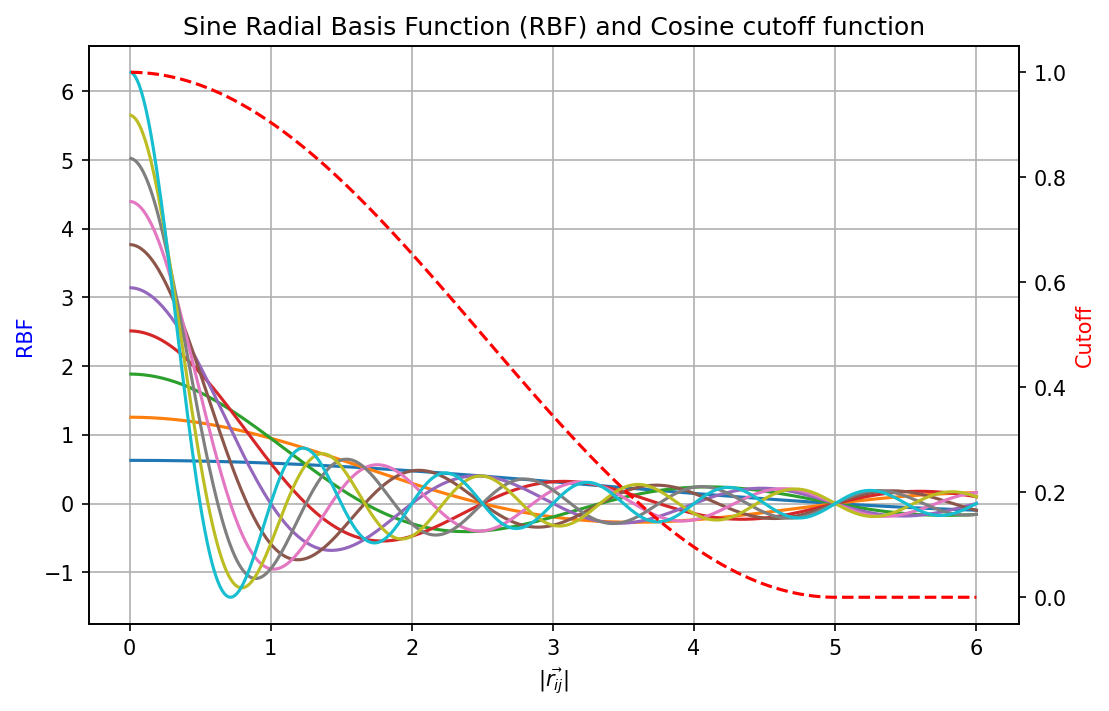

In [54]:
# 画出RBF和f_c函数
import numpy as np
import matplotlib.pyplot as plt

# 定义常量
r_c = 5.0
n_values = np.arange(10) + 1

# 定义向量长度范围
r_ij_norm = np.linspace(0.01, 6, 400)  # 超过rc的部分是为了展示fc的截断

# RBF 函数定义
def RBF(r_ij_norm):
    return np.sin(n * np.pi * r_ij_norm / r_c) / r_ij_norm

# fc 函数定义
def fc(r_ij_norm):
    mask = r_ij_norm < r_c
    result = np.zeros_like(r_ij_norm)
    result[mask] = 0.5 * (np.cos(np.pi * r_ij_norm[mask] / r_c) + 1)
    return result

# 绘制RBF函数
plt.figure(figsize=(8, 5), dpi=150)
for n in n_values:
    plt.plot(r_ij_norm, RBF(r_ij_norm))

plt.title('Sine Radial Basis Function (RBF) and Cosine cutoff function')
plt.xlabel(r'$|\vec{r_{ij}}|$')
plt.ylabel('RBF', color='b')
plt.grid(True)

ax1 = plt.gca()
ax2 = ax1.twinx()

# 绘制fc函数
ax2.plot(r_ij_norm, fc(r_ij_norm), 'r--')
ax2.set_ylabel('Cutoff', color='r')


plt.show()

我们掌握了这两个函数的写法后便可以把Message层给写出来了，如下所示

<div style="display: flex">
    <div style="flex: 1; text-align: left; margin: 5px;">
        <figure>
          <img src="figures/painn_message.png" alt="message"; style="width: 40%">
          <figcaption>Message layer</figcaption>
        </figure>
    </div>
</div>

In [71]:
# Message layer
class PainnMessage(nn.Module):
    """Message function"""
    def __init__(self, node_size: int, edge_size: int, cutoff: float):
        super().__init__()
        
        self.edge_size = edge_size
        self.node_size = node_size
        self.cutoff = cutoff
        
        self.scalar_message_mlp = nn.Sequential(
            nn.Linear(node_size, node_size),
            nn.SiLU(),
            nn.Linear(node_size, node_size * 3),
        )
        
        self.filter_layer = nn.Linear(edge_size, node_size * 3)

    # num_atoms x 128
    # num_pairs x 3, 2
    def forward(self, node_scalar, node_vector, edge, edge_diff, edge_dist):
        # remember to use v_j, s_j but not v_i, s_i        
        filter_weight = self.filter_layer(sinc_expansion(edge_dist, self.edge_size, self.cutoff))
        filter_weight = filter_weight * cosine_cutoff(edge_dist, self.cutoff).unsqueeze(-1)
        scalar_out = self.scalar_message_mlp(node_scalar)        
        filter_out = filter_weight * scalar_out[edge[:, 1]]
        
        gate_state_vector, gate_edge_vector, message_scalar = torch.split(
            filter_out, 
            self.node_size,
            dim = 1,
        )
        
        # num_pairs * 3 * node_size, num_pairs * node_size
        message_vector =  node_vector[edge[:, 1]] * gate_state_vector.unsqueeze(1) 
        edge_vector = gate_edge_vector.unsqueeze(1) * (edge_diff / edge_dist.unsqueeze(-1)).unsqueeze(-1)
        message_vector = message_vector + edge_vector
        
        # sum message
        residual_scalar = torch.zeros_like(node_scalar)
        residual_vector = torch.zeros_like(node_vector)
        residual_scalar.index_add_(0, edge[:, 0], message_scalar)          # add up message from neighbors
        residual_vector.index_add_(0, edge[:, 0], message_vector)          # add up message from neighbors
        
        # new node state
        new_node_scalar = node_scalar + residual_scalar
        new_node_vector = node_vector + residual_vector
        
        return new_node_scalar, new_node_vector

#### 几个注意点：
1. 网络中出现的各个输入输出量的维度，以node_size=128为例，$\vec{v}$维度为$n_{pair}\times 128\times 3$，$s$维度为$n_{pair}\times 128$，${\vec{r_{ij}}}$维度为$n_{pair}\times 3$
2. 收集neighbor的信息是通过`index_add`函数来实现的，这个函数非常重要，在后面的计算中将会大量出现
3. 这里使用了ResNet（何恺明2015年paper）中提出的skip connection (x = x + f(x))，使网络的梯度不容易爆炸或者消失

接着我们再来讲update层，update层相对message层要简单一些。注意一下原paper里的$\vec{v_j}$和$s_j$其实写错了，应该是$\vec{v_i}$和$s_i$，update层与周围原子的信息无关，仅仅是对feature进行更新而已。这里用到的东西也比较简单，全部都是linear层，注意一下维度就好。

<div style="display: flex">
    <div style="flex: 1; text-align: left; margin: 5px;">
        <figure>
          <img src="figures/painn_update.png" alt="update"; style="width: 40%">
          <figcaption>Update layer</figcaption>
        </figure>
    </div>
</div>

In [72]:
class PainnUpdate(nn.Module):
    """Update function"""
    def __init__(self, node_size: int):
        super().__init__()
        
        self.update_U = nn.Linear(node_size, node_size)       # rotational equivariant
        self.update_V = nn.Linear(node_size, node_size)
        
        self.update_mlp = nn.Sequential(
            nn.Linear(node_size * 2, node_size),
            nn.SiLU(),
            nn.Linear(node_size, node_size * 3),
        )
        
    def forward(self, node_scalar, node_vector):
        Uv = self.update_U(node_vector)
        Vv = self.update_V(node_vector)
        
        Vv_norm = torch.linalg.norm(Vv, dim=1)
        mlp_input = torch.cat((Vv_norm, node_scalar), dim=1)
        mlp_output = self.update_mlp(mlp_input)
        
        a_vv, a_sv, a_ss = torch.split(
            mlp_output,                                        
            node_vector.shape[-1],                                       
            dim = 1,
        )
        
        delta_v = a_vv.unsqueeze(1) * Uv
        inner_prod = torch.sum(Uv * Vv, dim=1)
        delta_s = a_sv * inner_prod + a_ss
        
        return node_scalar + delta_s, node_vector + delta_v

注意Update层同样使用了skip connection。有了以上两个block后，我们马上就可以开始正式写我们的PaiNN model，注意下还有个蓝色的全连接层block，但这个block的内容非常简单，我们不需要为此专门写一个layer。直接参照`PainnMessage`和`PainnUpdate`中MLP层的写法就可以。

超参数：定义网络构成
参数：网络里的参数

In [79]:
atom_embedding.state_dict()

OrderedDict([('weight',
              tensor([[-0.8806, -0.2655, -0.8794,  ...,  0.3070,  0.4760,  1.9808],
                      [ 0.0052,  0.5386,  0.7162,  ...,  0.8136, -0.5920, -0.4331],
                      [ 1.5474, -0.7835, -1.0827,  ..., -1.3605, -0.0216, -0.5792],
                      ...,
                      [ 0.5929,  0.6181,  0.5072,  ..., -0.3231, -1.1753,  0.3730],
                      [-0.5403, -0.4248, -0.6867,  ..., -0.0200,  0.0036, -0.2260],
                      [ 1.0172, -0.0034,  0.1480,  ..., -0.8164,  0.2277, -0.1105]]))])

In [73]:
from typing import Dict

class PainnModel(nn.Module):
    """PainnModel without edge updating"""
    def __init__(
        self, 
        num_interactions: int, 
        node_size: int,
        cutoff: float,
        normalization: bool=True,
        target_mean: float=0.0,
        target_stddev: float=1.0,
        atomwise_normalization: bool=True,
        **kwargs,
    ):
        super().__init__(**kwargs)
        
        num_embedding = 119   # number of all elements
        self.cutoff = cutoff
        self.num_interactions = num_interactions
        self.node_size = node_size
        self.edge_size = 20
            
        # Setup atom embeddings
        self.atom_embedding = nn.Embedding(num_embedding, node_size)

        # Setup message-passing layers
        self.message_layers = nn.ModuleList(
            [
                PainnMessage(self.node_size, self.edge_size, self.cutoff)
                for _ in range(self.num_interactions)
            ]
        )
        self.update_layers = nn.ModuleList(
            [
                PainnUpdate(self.node_size)
                for _ in range(self.num_interactions)
            ]            
        )
        
        # Setup readout function
        self.readout_mlp = nn.Sequential(
            nn.Linear(self.node_size, self.node_size),
            nn.SiLU(),
            nn.Linear(self.node_size, 1),
        )

        # Normalisation constants
        self.register_buffer("normalization", torch.tensor(normalization))
        self.register_buffer("atomwise_normalization", torch.tensor(atomwise_normalization))
        self.register_buffer("normalize_stddev", torch.tensor(target_stddev))
        self.register_buffer("normalize_mean", torch.tensor(target_mean))

    def forward(self, input_dict: Dict[str, torch.Tensor], compute_forces: bool=True) -> Dict[str, torch.Tensor]:
        # access atoms properties needed
        num_atoms = input_dict['num_atoms']
        total_atoms = int(torch.sum(num_atoms))
        num_pairs = input_dict['num_pairs']
        edge = input_dict['pairs']
        edge_diff = input_dict['n_diff']
        image_idx = input_dict['image_idx'] 

        if compute_forces:
            edge_diff.requires_grad_()
        edge_dist = torch.linalg.norm(edge_diff, dim=1)
        
        # 获取初始node_scalar和node_vector
        node_scalar = self.atom_embedding(input_dict['elems'])
        node_vector = torch.zeros((total_atoms, 3, self.node_size),
                                  device=edge_diff.device,
                                  dtype=edge_diff.dtype,
                                 )
        
        for message_layer, update_layer in zip(self.message_layers, self.update_layers):
            node_scalar, node_vector = message_layer(node_scalar, node_vector, edge, edge_diff, edge_dist)
            node_scalar, node_vector = update_layer(node_scalar, node_vector)
        
        node_scalar = self.readout_mlp(node_scalar)
        node_scalar.squeeze_()
        
        energy = torch.zeros_like(input_dict['num_atoms'], dtype=edge_diff.dtype)  
        energy.index_add_(0, image_idx, node_scalar)

        # Apply (de-)normalization
        if self.normalization:
            normalizer = self.normalize_stddev
            energy = normalizer * energy
            mean_shift = self.normalize_mean
            if self.atomwise_normalization:
                mean_shift = input_dict["num_atoms"] * mean_shift
            energy = energy + mean_shift

        result_dict = {'energy': energy}
        
        # 力的计算
        if compute_forces:
            grad_outputs : List[Optional[torch.Tensor]] = [torch.ones_like(energy)]    # for model deploy
            dE_ddiff = torch.autograd.grad(
                [energy,],
                [edge_diff,],
                grad_outputs=grad_outputs,
                retain_graph=True,
                create_graph=True,
            )
            dE_ddiff = torch.zeros_like(edge_diff) if dE_ddiff is None else dE_ddiff[0]   # for torch.jit.script
            assert dE_ddiff is not None
            
            # diff = R_j - R_i, so -dE/dR_j = -dE/ddiff, -dE/R_i = dE/ddiff
            i_forces = torch.zeros((total_atoms, 3), device=edge_diff.device, dtype=edge_diff.dtype)
            j_forces = torch.zeros_like(i_forces)
            i_forces.index_add_(0, edge[:, 0], dE_ddiff)
            j_forces.index_add_(0, edge[:, 1], dE_ddiff)
            forces = i_forces - j_forces
            
            result_dict['forces'] = forces
            
        return result_dict

scatter_add scatter_mean

能量的计算非常直观，我们使用一个全连接MLP层就可以得到每个原子的能量，利用`index_add`函数将这些能量加起来就得到了每个结构的总能量。

相较之下，力的计算稍微有一些复杂，它主要是通过以下公式推导而得到的：

$$
\begin{align}
\vec{f_{ij}} = \vec{f_{i}} = -\frac{\partial E}{\partial \vec{r_i}} & = -(\frac{\partial E}{\partial \vec{r_{ij}}}\frac{\partial \vec{r_{ij}}}{\partial \vec{r_i}} + \frac{\partial E}{\partial \vec{r_{ji}}}\frac{\partial \vec{r_{ji}}}{\partial \vec{r_i}} + \frac{\partial E}{\partial \vec{r_{kj}}}\frac{\partial \vec{r_{kj}}}{\partial \vec{r_i}}) \\
& = \frac{\partial E}{\partial \vec{r_{ij}}} - \frac{\partial E}{\partial \vec{r_{ji}}}
\end{align}
$$

$\frac{\partial \vec{r_{ij}}}{\partial \vec{r_i}}= \frac{\partial \vec{r_{j}} - \vec{r_{i}}}{\partial \vec{r_i}}$ 

得益于PyTorch的自动微分计算，我们可以很容易地使用`torch.autograd.grad`函数计算出$\frac{\partial{E}}{\partial{\vec{r_{ij}}}}$，接着使用上述公式便能计算出每个原子的受力情况。

注意这里有一个很重要的步骤是de-normalization，也就是对数据进行归一化。我们知道数据的归一化方式为：
$$
\tilde{x} = \frac{x-\mu}{\sigma(x)}
$$
其中$\mu$和$\sigma$分别为平均值和标准差。归一化对一些数据尤为重要，很多时候是否归一化甚至比模型的结构对最终模型质量的影响还要更大。

对训练数据归一化后，我们会得到平均值和标准差，在做预测时，需要对预测值做反归一化，最后得到的结果才能用于实际计算。

注意我们这里使用了atomwise_normalization，对每个原子的能量归一化而非整个结构。这样做是为了让模型可以更好适用于原子数不同的结构，否则模型对原子数不同的结构预测效果将会非常差。

## 项目二. 模型的训练与调试

### 1. 模型训练前的准备（数据归一化，损失函数和优化器）

上一节中我们讲完了如何自己动手实现一个GNN机器学习力场，接下来我们将试着自己动手训练这个模型。

还记得我们之前准备的数据吗？直接把上面的代码拷贝过来再运行一次，就得到了train_data和val_data

In [81]:
cutoff = 5.0

# images = read('/home/xinyang/jht_dataset.traj', '::10')
# dataset = AseDataset(images, cutoff=cutoff)
dataset = AseDataset('dataset_1593.traj', cutoff=cutoff)
np.random.seed(3407)
datasplits = split_data(dataset, val_ratio=0.1, test_ratio=0.1)

train_loader = torch.utils.data.DataLoader(
    dataset=datasplits['train'],
    batch_size=16,
    collate_fn=collate_atomsdata,
)
val_loader = torch.utils.data.DataLoader(
    datasplits['validation'],
    batch_size=16,
    collate_fn=collate_atomsdata,
)
test_loader = torch.utils.data.DataLoader(
    datasplits['test'],
    batch_size=16,
    collate_fn=collate_atomsdata,
)


print(f'Dataset size: {len(dataset)}, training set size: {len(datasplits["train"])}, validation set size: {len(datasplits["validation"])}, test set size: {len(datasplits["test"])}')

Dataset size: 1593, training set size: 1275, validation set size: 159, test set size: 159


接着我们要计算一下这些数据的平均值和标准差，用于数据归一化。

In [82]:
def get_normalization(dataset, per_atom=True):
    energies = []
    for sample in dataset:
        e = sample['energy']
        if per_atom:
            e /= sample['num_atoms']
        energies.append(e)
    energies = torch.cat(energies)
    mean = torch.mean(energies).item()
    stddev = torch.std(energies).item()

    return mean, stddev

mean, stddev = get_normalization(datasplits['train'], per_atom=True)
print(f"target_mean={mean:.3f}, target_stddev={stddev:.3f}")

target_mean=-5.745, target_stddev=0.003


接着创建我们的模型

In [95]:
num_layers = 3
node_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = PainnModel(
    num_interactions=num_layers,
    node_size=node_size,
    cutoff=cutoff,
    normalization=True,
    target_mean=mean,
    target_stddev=stddev,
    atomwise_normalization=True,
)

# 把网络放到GPU上
net.to(device)

PainnModel(
  (atom_embedding): Embedding(119, 128)
  (message_layers): ModuleList(
    (0-2): 3 x PainnMessage(
      (scalar_message_mlp): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=384, bias=True)
      )
      (filter_layer): Linear(in_features=20, out_features=384, bias=True)
    )
  )
  (update_layers): ModuleList(
    (0-2): 3 x PainnUpdate(
      (update_U): Linear(in_features=128, out_features=128, bias=True)
      (update_V): Linear(in_features=128, out_features=128, bias=True)
      (update_mlp): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=384, bias=True)
      )
    )
  )
  (readout_mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

设置模型优化器optimizer，学习率调度器scheduler和损失函数loss。scheduler的设置是必要的，因为当模型逐渐趋于合理时，我们希望学习率小一些以接近全局最优。

In [96]:
learning_rate = 0.0005

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# scheduler
scheduler_fn = lambda step: 0.96 ** (step / 100000)             # 每训练10万步减小学习率
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, scheduler_fn)

criterion = torch.nn.MSELoss()

设置误差函数，用来计算RMSE和MAE等误差量。

In [97]:
# 误差计算的损失函数
def update_metrics(metrics, batch, outputs, e_loss, f_loss):
    # Accumulate counts of atoms and structures
    metrics['count_a'] += batch['forces'].shape[0]
    metrics['count_s'] += batch['energy'].shape[0]
    
    # Accumulate squared errors and absolute errors
    e_diff = outputs["energy"].detach() - batch["energy"]
    f_diff = outputs["forces"].detach() - batch["forces"]
    metrics['e_se'] += e_diff.square().sum()
    metrics['e_ae'] += e_diff.abs().sum()
    metrics['f_se'] += f_diff.square().sum()
    metrics['f_ae'] += f_diff.abs().sum()
    
    # Accumulate losses
    metrics['loss_e'] += e_loss.detach().item() * batch['energy'].shape[0]
    metrics['loss_f'] += f_loss.detach().item() * batch['forces'].shape[0]

def reset_metrics(metrics):
    # Reset all metrics
    for k in metrics:
        metrics[k] = 0

def compute_final_metrics(metrics):
    # Compute final metrics such as RMSE, MAE, etc.
    final_metrics = {}
    final_metrics['e_rmse'] = torch.sqrt(metrics['e_se'] / metrics['count_s'])
    final_metrics['e_mae'] = metrics['e_ae'] / metrics['count_s']
    final_metrics['f_rmse'] = torch.sqrt(metrics['f_se'] / metrics['count_a'] / 3)
    final_metrics['f_mae'] = metrics['f_ae'] / metrics['count_a'] / 3
    final_metrics['loss_e'] = metrics['loss_e'] / metrics['count_s']
    final_metrics['loss_f'] = metrics['loss_f'] / metrics['count_a']
    final_metrics['total_loss'] = final_metrics['loss_e'] + final_metrics['loss_f']
    final_metrics['cost'] = metrics['cost']

    # 把metrics从GPU转移到CPU
    for k, v in final_metrics.items():
        if isinstance(v, torch.Tensor):
            final_metrics[k] = v.item()
            
    return final_metrics

def log_metrics(metrics, batch_idx, total_batches):
    # Log metrics
    print(f'Batch {batch_idx}/{total_batches}: ' + ", ".join([f"{k}= {v:10.3g}" for k, v in metrics.items()]))

### 2. 模型训练

准备好以上部分后，我们便可以开始训练我们的模型了

In [89]:
forces_weight = 98
energy_weight = 2

def run_epoch(
    net, 
    dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    device,
    energy_weight,
    forces_weight,
    log_freq=10,
    is_training=True):
    # Initialize metrics
    metrics = {
        'count_a': 0, 'count_s': 0, 'cost': 0,
        'e_se': 0, 'e_ae': 0, 'f_se': 0, 'f_ae': 0, 
        'loss_e': 0, 'loss_f': 0,
    }
    
    # Set network mode
    net.train(is_training)
    
    if is_training:
        print("Training:")

    # Loop over batches
    for batch_idx, batch_host in enumerate(dataloader):
        start = time.time()
        
        # Transfer to device
        batch = {k: v.to(device=device, non_blocking=True) for (k, v) in batch_host.items()}
        
        # Reset gradients if training
        if is_training:
            optimizer.zero_grad()
        
        # Forward pass
        outputs = net(batch, compute_forces=True)
        
        # Calculate losses
        e_loss = criterion(outputs["energy"], batch["energy"]) * energy_weight
        f_loss = criterion(outputs['forces'], batch['forces']) * forces_weight
        total_loss = e_loss + f_loss
        
        # Update metrics
        update_metrics(metrics, batch, outputs, e_loss, f_loss)
        
        # Backward pass and optimization if training
        if is_training:
            total_loss.backward()
            optimizer.step()
            scheduler.step()
        
        # Update training cost
        metrics['cost'] += time.time() - start
        
        # Logging during training
        if is_training and (batch_idx + 1) % log_freq == 0:
            log_metrics(compute_final_metrics(metrics), batch_idx + 1, len(dataloader))
            reset_metrics(metrics)

    # Compute final metrics for the epoch if validation
    if not is_training:
        final_metrics = compute_final_metrics(metrics)
        print("\nValidation:")
        log_metrics(final_metrics, batch_idx + 1, len(dataloader))
        return final_metrics

In [90]:
max_epoch = 10

for i in range(max_epoch):
    print(f"\nEpoch {i+1}/{max_epoch}:")
    
    # run training
    run_epoch(net, train_loader, criterion, optimizer, scheduler, device, energy_weight, forces_weight, log_freq=10, is_training=True)
    
    # run validation
    final_metrics = run_epoch(net, val_loader, criterion, optimizer, scheduler, device, energy_weight, forces_weight, log_freq=10, is_training=False)


Epoch 1/10:
Training:
Batch 10/80: e_rmse=       0.53, e_mae=      0.406, f_rmse=     0.0429, f_mae=     0.0264, loss_e=      0.563, loss_f=      0.181, total_loss=      0.743, cost=      0.598
Batch 20/80: e_rmse=      0.519, e_mae=       0.41, f_rmse=      0.041, f_mae=     0.0253, loss_e=      0.538, loss_f=      0.164, total_loss=      0.703, cost=      0.285
Batch 30/80: e_rmse=      0.523, e_mae=      0.405, f_rmse=     0.0409, f_mae=     0.0248, loss_e=      0.546, loss_f=      0.164, total_loss=       0.71, cost=      0.292
Batch 40/80: e_rmse=      0.568, e_mae=      0.472, f_rmse=     0.0353, f_mae=     0.0198, loss_e=      0.645, loss_f=      0.122, total_loss=      0.767, cost=       0.29
Batch 50/80: e_rmse=      0.444, e_mae=      0.334, f_rmse=     0.0282, f_mae=     0.0152, loss_e=      0.395, loss_f=     0.0782, total_loss=      0.473, cost=      0.288
Batch 60/80: e_rmse=      0.491, e_mae=      0.427, f_rmse=     0.0212, f_mae=     0.0126, loss_e=      0.481, loss_f

至此我们便训练好了我们第一个GNN模型，可以发现模型的训练速度还是非常快的。我们可以用torch.save把这个模型保存下来（不是可以用，而是必须用，否则就白算了）

In [91]:
torch.save(net, 'trained_model.pth')

当然我们也可以选择在训练代码中自动保存模型。当模型训练过久时，可能出现训练集的误差显著小于验证集，此时便表示我们的模型训练正在过拟合。我们可以使用early-stopping早停技术来提前结束我们的模型训练。以下代码包含了如何自动保存最优模型，如何early-stopping。

In [92]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, best_loss):
        if val_loss - best_loss > self.min_delta:
            self.counter +=1
            if self.counter >= self.patience:        # 当 val_loss > best_loss 达到 patience 次数时，早停条件成立
                self.early_stop = True
                
        return self.early_stop

exponential moving average

In [98]:
max_epoch = 100
best_val_loss = np.inf       # 把初始最低loss设为无限大 

early_stop = EarlyStopping(patience=20)
metrics = []         # 收集metrics用来画图

for i in range(max_epoch):
    print(f"\nEpoch {i+1}/{max_epoch}:")
    
    # run training
    run_epoch(net, train_loader, criterion, optimizer, scheduler, device, energy_weight, forces_weight, log_freq=10, is_training=True)
    
    # run validation
    final_metrics = run_epoch(net, val_loader, criterion, optimizer, scheduler, device, energy_weight, forces_weight, log_freq=10, is_training=False)

    # collect metrics
    metrics.append(final_metrics)
    
    # early_stopping
    if not early_stop(final_metrics['total_loss'], best_val_loss):
        if final_metrics['total_loss'] < best_val_loss:
            best_val_loss = final_metrics['total_loss']
            torch.save(net, 'best_model.pt')
    else:
        break       # 当早停条件成立时，跳出循环


Epoch 1/100:
Training:
Batch 10/80: e_rmse=      0.528, e_mae=      0.403, f_rmse=     0.0428, f_mae=     0.0262, loss_e=      0.557, loss_f=       0.18, total_loss=      0.737, cost=      0.291
Batch 20/80: e_rmse=      0.505, e_mae=      0.386, f_rmse=       0.04, f_mae=     0.0244, loss_e=      0.511, loss_f=      0.157, total_loss=      0.668, cost=      0.285
Batch 30/80: e_rmse=      0.515, e_mae=      0.426, f_rmse=     0.0382, f_mae=      0.022, loss_e=       0.53, loss_f=      0.143, total_loss=      0.673, cost=      0.287
Batch 40/80: e_rmse=      0.521, e_mae=      0.404, f_rmse=     0.0318, f_mae=     0.0168, loss_e=      0.542, loss_f=     0.0992, total_loss=      0.642, cost=      0.283
Batch 50/80: e_rmse=      0.438, e_mae=      0.338, f_rmse=     0.0238, f_mae=     0.0139, loss_e=      0.383, loss_f=     0.0556, total_loss=      0.439, cost=      0.284
Batch 60/80: e_rmse=      0.489, e_mae=       0.42, f_rmse=     0.0201, f_mae=      0.012, loss_e=      0.477, loss_

我们来画一下图，观察一下loss，e_rmse，f_rmse是如何变化的。

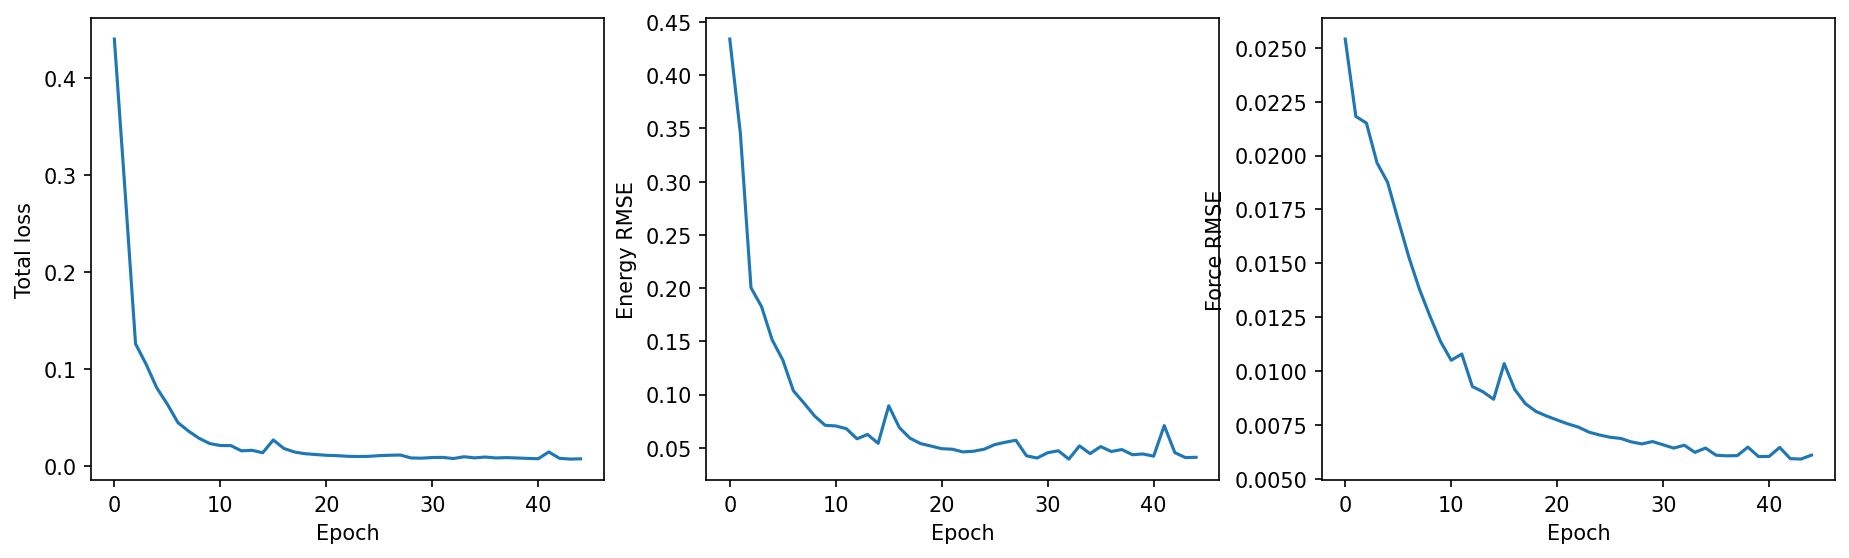

In [99]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=150)

axes[0].plot([m['total_loss'] for m in metrics])
axes[1].plot([m['e_rmse'] for m in metrics])
axes[2].plot([m['f_rmse'] for m in metrics])

axes[0].set_ylabel('Total loss')
axes[1].set_ylabel('Energy RMSE')
axes[2].set_ylabel('Force RMSE')

for ax in axes:
    ax.set_xlabel('Epoch')

plt.subplots_adjust()

可以看到Loss确实是一直在下降的，RMSE也在变得越来越好。

### 3. 模型的评估

从训练结果中我们看到模型的表现非常好，可能有人怀疑这个结果究竟准不准确，我们可以使用独立测试集来评估模型的表现。

In [114]:
# 记录所有energy和force
e_dft, f_dft, e_ml, f_ml = [], [], [], []

for batch_host in test_loader:
    batch = {k: v.to(device) for k, v in batch_host.items()}
    results = net(batch)

    # 获取energy和forces
    e_dft.append(batch['energy'].detach().cpu().numpy())
    f_dft.append(batch['forces'].detach().cpu().numpy())
    e_ml.append(results['energy'].detach().cpu().numpy())
    f_ml.append(results['forces'].detach().cpu().numpy())

# concat一下
e_dft = np.concatenate(e_dft)
f_dft = np.concatenate(f_dft).flatten()
e_ml = np.concatenate(e_ml)
f_ml = np.concatenate(f_ml).flatten()

数据收集好了我们就可以画图了。

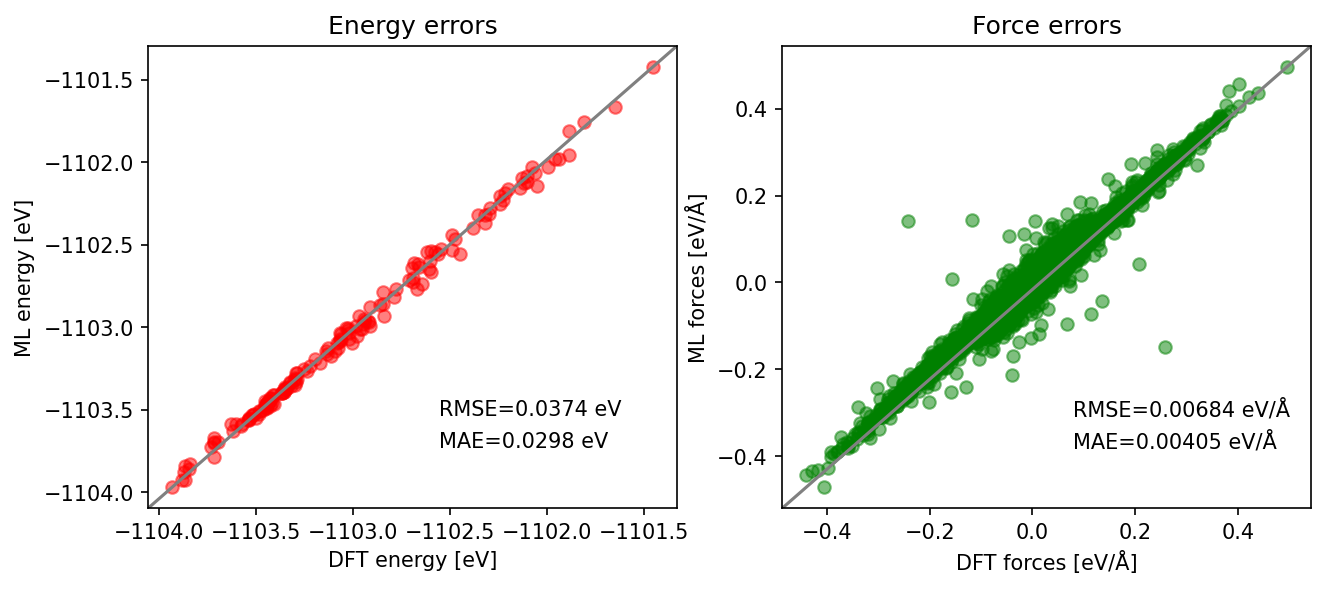

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=150)

#画图
axes[0].plot(e_dft, e_ml, 'ro', alpha=0.5)
axes[1].plot(f_dft, f_ml, 'go', alpha=0.5)

# 设置图片格式等
for ax in axes:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())
    ax.plot(ax.get_xlim(), ax.get_ylim(), c='grey')

axes[0].set_xlabel('DFT energy [eV]')
axes[0].set_ylabel('ML energy [eV]')
axes[0].set_title('Energy errors')
axes[1].set_xlabel('DFT forces [eV/Å]')
axes[1].set_ylabel('ML forces [eV/Å]')
axes[1].set_title('Force errors')

# 计算MAE, RMSE
axes[0].text(0.55, 0.2, f'RMSE={np.sqrt(np.mean(np.square(e_dft - e_ml))):.3g} eV', transform=axes[0].transAxes)
axes[0].text(0.55, 0.13, f'MAE={np.mean(np.abs(e_dft - e_ml)):.3g} eV', transform=axes[0].transAxes)

axes[1].text(0.55, 0.2, f'RMSE={np.sqrt(np.mean(np.square(f_dft - f_ml))):.3g} eV/Å', transform=axes[1].transAxes)
axes[1].text(0.55, 0.13, f'MAE={np.mean(np.abs(f_dft - f_ml)):.3g} eV/Å', transform=axes[1].transAxes)

plt.show()

Force: 6.6 meV/Å 
Energy: 0.045 eV

In [105]:
0.045 / 192 * 1000 

0.234375

最后发现，模型的效果确实是如训练时所观察到的一样好。

### 小测验：
之前提到归一化对训练的影响非常大，能否尝试一下不使用归一化来训练模型？

In [ ]:
# 在此处输入你的代码

# net = PainnModel(
#     num_interactions=num_layers, 
#     node_size=node_size,
#     cutoff=cutoff,
#     normalization=False,
#     atomwise_normalization=False,
# )

# # 把网络放到GPU上
# net.to(device)


### 开放性问题
1. 怎么把训练的过程记录到文件中，实时观察输出？（使用python logging模块来输出log）
2. 训练一个模型要记录的超参数太多了，怎么去管理这些超参数？（使用argparse模块来管理所有的参数）
3. PaiNN是如何实现旋转等变性的？
4. 如何防止过拟合？(early stopping，exponential moving average)

最后我们提供训练的所有代码，后续大家可以自己修改一些参数来测试一下不同模型的表现。

In [106]:
cutoff = 5.0

# images = read('/home/xinyang/jht_dataset.traj', '::10')
# dataset = AseDataset(images, cutoff=cutoff)
dataset = AseDataset('dataset_1593.traj', cutoff=cutoff)
np.random.seed(123456)
datasplits = split_data(dataset, val_ratio=0.1, test_ratio=0.1)

train_loader = torch.utils.data.DataLoader(
    dataset=datasplits['train'],
    batch_size=16,
    collate_fn=collate_atomsdata,
)
val_loader = torch.utils.data.DataLoader(
    datasplits['validation'],
    batch_size=16,
    collate_fn=collate_atomsdata,
)
test_loader = torch.utils.data.DataLoader(
    datasplits['test'],
    batch_size=16,
    collate_fn=collate_atomsdata,
)


print(f'Dataset size: {len(dataset)}, training set size: {len(datasplits["train"])}, validation set size: {len(datasplits["validation"])}, test set size: {len(datasplits["test"])}')

mean, stddev = get_normalization(datasplits['train'], per_atom=True)
print(f"target_mean={mean:.3f}, target_stddev={stddev:.3f}")

num_layers = 3
node_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = PainnModel(
    num_interactions=num_layers, 
    node_size=node_size,
    cutoff=cutoff,
    normalization=False,
    # target_mean=mean,
    # target_stddev=stddev,
    atomwise_normalization=False,
)

# 把网络放到GPU上
net.to(device)

learning_rate = 0.0005

# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# scheduler
scheduler_fn = lambda step: 0.96 ** (step / 100000)             # 每训练10万步减小学习率
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, scheduler_fn)

criterion = torch.nn.MSELoss()

# 训练
max_epoch = 100
best_val_loss = np.inf       # 把初始最低loss设为无限大 

early_stop = EarlyStopping(patience=20)
metrics = []         # 收集metrics用来画图

for i in range(max_epoch):
    print(f"\nEpoch {i+1}/{max_epoch}:")
    
    # run training
    run_epoch(net, train_loader, criterion, optimizer, scheduler, device, energy_weight, forces_weight, log_freq=10, is_training=True)
    
    # run validation
    final_metrics = run_epoch(net, val_loader, criterion, optimizer, scheduler, device, energy_weight, forces_weight, log_freq=10, is_training=False)

    # collect metrics
    metrics.append(final_metrics)
    
    # early_stopping
    if not early_stop(final_metrics['total_loss'], best_val_loss):
        if final_metrics['total_loss'] < best_val_loss:
            best_val_loss = final_metrics['total_loss']
            torch.save(net, 'bad_model.pth')
    else:
        break       # 当早停条件成立时，跳出循环

Dataset size: 1593, training set size: 1275, validation set size: 159, test set size: 159
target_mean=-5.745, target_stddev=0.003

Epoch 1/100:
Training:
Batch 10/80: e_rmse=        884, e_mae=        860, f_rmse=      0.453, f_mae=      0.287, loss_e=   1.56e+06, loss_f=       20.1, total_loss=   1.56e+06, cost=      0.287
Batch 20/80: e_rmse=        264, e_mae=        242, f_rmse=       2.58, f_mae=       1.92, loss_e=   1.39e+05, loss_f=        653, total_loss=    1.4e+05, cost=      0.285
Batch 30/80: e_rmse=        142, e_mae=        131, f_rmse=       1.23, f_mae=      0.932, loss_e=   4.04e+04, loss_f=        149, total_loss=   4.06e+04, cost=      0.282
Batch 40/80: e_rmse=       76.5, e_mae=       67.5, f_rmse=       1.16, f_mae=      0.892, loss_e=   1.17e+04, loss_f=        133, total_loss=   1.18e+04, cost=      0.284
Batch 50/80: e_rmse=       51.6, e_mae=       43.7, f_rmse=       1.08, f_mae=       0.83, loss_e=   5.32e+03, loss_f=        115, total_loss=   5.44e+03, cos

KeyboardInterrupt: 

### 4. 模型的部署

最后我们还可以选择把训练好的模型部署好，这样做的好处是模型的运行可以不依赖我们之前写好的代码，也不依赖pytorch，它甚至可以不依赖python来运行。此外，我们甚至还可以拿部署好的模型到Lammps、OpenMM等软件上使用。

模型的部署有几种方法，分别是Trace，Script，以及PyTorch 2.0以后新出的功能`torch.compile`。关于这几种方法的区别和特点，大家可以自行去查找相关的资料。

模型的部署其实非常tricky，有非常多的地方需要注意，很多代码要重写，比如大家能注意到在不同layer里我们都标记了输入和输出的数据格式应该是怎么样的，这些就是为模型部署准备的。这里我们使用Script方法来部署训练好的模型。

In [113]:
net = torch.load('best_model.pth')

In [118]:
net

PainnModel(
  (atom_embedding): Embedding(119, 128)
  (message_layers): ModuleList(
    (0-2): 3 x PainnMessage(
      (scalar_message_mlp): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=384, bias=True)
      )
      (filter_layer): Linear(in_features=20, out_features=384, bias=True)
    )
  )
  (update_layers): ModuleList(
    (0-2): 3 x PainnUpdate(
      (update_U): Linear(in_features=128, out_features=128, bias=True)
      (update_V): Linear(in_features=128, out_features=128, bias=True)
      (update_mlp): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): SiLU()
        (2): Linear(in_features=128, out_features=384, bias=True)
      )
    )
  )
  (readout_mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [116]:
compiled_model = torch.jit.script(net)

In [117]:
compiled_model

RecursiveScriptModule(
  original_name=PainnModel
  (atom_embedding): RecursiveScriptModule(original_name=Embedding)
  (message_layers): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=PainnMessage
      (scalar_message_mlp): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Linear)
        (1): RecursiveScriptModule(original_name=SiLU)
        (2): RecursiveScriptModule(original_name=Linear)
      )
      (filter_layer): RecursiveScriptModule(original_name=Linear)
    )
    (1): RecursiveScriptModule(
      original_name=PainnMessage
      (scalar_message_mlp): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(original_name=Linear)
        (1): RecursiveScriptModule(original_name=SiLU)
        (2): RecursiveScriptModule(original_name=Linear)
      )
      (filter_layer): RecursiveScriptModule(original_name=Linear)
    )
    (2): Recurs

In [119]:
torch.jit.save(compiled_model, 'compiled_model.pt')

部署好以后我们前两个项目，模型的搭建和训练就完成了。